# Libreta Pruebas Dataset test

Preparamos el entorno para trabajar con nuestro dataset. 
<br><br>
Un **dataset** es una colección estructurada de datos. Rpresenta el conjunto de datos en sí mismo y define cómo se acceden y transforman los datos. 
<br><br>
En nuestro caso particular, trabajaremos con imágenes CSV correspondientes a mamografías. A continuación, se muestra cómo manipulamos dichas imágenes.  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..') # agrega el directorio padre (..) al path para poder importar módulos desde un nivel superior
import numpy as np

!pwd # para imprimir el directorio actual

from pathlib import Path
from utils.utils import show_mask_image
import matplotlib.pyplot as plt

from data.ddsm_dataset import get_train_dataloader, get_test_dataloader

split_csv = '../resources/ddsm/ddsm_nikulin_partitions/train_filenames.txt' # son los nombres de las imágenes que se usarán para entrenar
# Ejemplo formato: 
# cancers/cancer_05/case0146/C_0146_1.LEFT_MLO.png,train
# benigns/benign_12/case1795/A_1795_1.RIGHT_CC.png,train


ddsm_annotations = '../resources/ddsm/ddsm_annotations_16bits_1120_896.json.gz'
root_dir = '/home/Data/mamo/DDSM_png_16bit_1120x896'
transform_generator = None
patch_size = 224
convert_to_rgb = False
include_normals = True
normalize_input = True

/home/eblanov/proymam2/Mammography/elsa/notebooks


Obtenemos el dataloader. 

El **dataloader** es una herramienta que ayuda a cargar los datos de manera eficiente cuando entrenas un modelo (minibatches). 

La función de a continuación crea y devuelve un dataloader para entrenar un modelo con imágenes del dataset DDSM. Hace lo siguiente: 
- Transformación RandomAffineTransform().
- Muestreo de parches (PatchSampler).
- Creación del dataset.
- Muestreo balanceado de batches.
- DataLoader.

In [3]:
train_dl = get_train_dataloader(split_csv, ddsm_annotations, root_dir, patch_size, batch_size=30, 
                        convert_to_rgb = convert_to_rgb, shuffle=True, num_workers=4, return_mask=True, 
                        subset_size=None, include_normals=include_normals,
                        normalize_input = True) 

train_ds = train_dl.dataset  

loading annotations
Number of annotations:  4664
Number of annotations after filtering split:  3263
Number of abnormal annotations:  3263
Including 2196 normal images
Number of annotations after adding normals:  5459
Number of annotations after filtering OTHER_BENIGN (18 in total)  5459
Number of classes:  5
Batch size:  30


Number of samples after filtering:  1119
Test dataset length: 1119
Batch size: 3
torch.Size([32, 3, 224, 224])


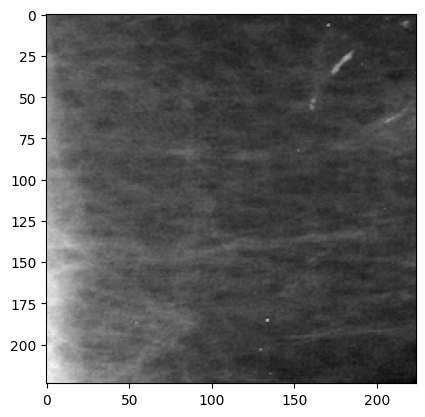

tensor(1.2876)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [10]:

patches_root = "/home/Data/mamo/eval_patches_16bits_224_test_nikulin"
batch_size=32
return_mask=True
convert_to_rgb = True
format_img = 'npy'



test_dl = get_test_dataloader(patches_root, batch_size=batch_size, return_mask=return_mask,
                             convert_to_rgb = convert_to_rgb, format_img = 'npy')

test_ds = test_dl.dataset
print(f"Test dataset length: {len(test_ds)}")


batch = next(iter(test_dl))
print(f"Batch size: {len(batch)}")
imgs = batch[0]
labels = batch[1]
masks = batch[2]


print(imgs.shape) # [batch_size, channels, height, width]

plt.imshow(imgs[0,0], cmap='gray')
plt.show()

print(imgs[0,0].mean())
print(labels)






In [4]:
print("Train DS: ", len(train_ds))
all_targets = train_ds.get_all_targets()

print("All targets: ", len(all_targets))

Train DS:  8722
All targets:  8722


Visualizamos una imagen.

Image:  (1, 224, 224) float32
Label:  4
Mask:  (224, 224)


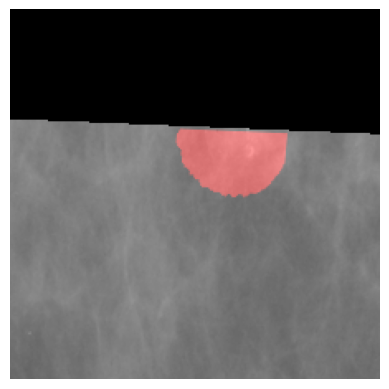

In [5]:
image, label, mask = train_ds[670]
print("Image: ", image.shape, image.dtype)
print("Label: ", label)
print("Mask: ", mask.shape)

show_mask_image(image[0], mask)

Veamos cuántas imágenes de cada tipo hay.

In [6]:
from collections import Counter

all_targets = train_ds.get_all_targets()
print(Counter(all_targets))

print(len(train_ds)/5)

Counter({'NORMAL': 5459, 'MASS_MALIGNANT': 963, 'MASS_BENIGN': 913, 'CALCIFICATION_BENIGN': 695, 'CALCIFICATION_MALIGNANT': 692})
1744.4


En cada bach queríamos una cantidad similar de imágenes de cada clase. Para verificar que esto se cumple, podemos imprimir las clases de un batch.

In [7]:
from collections import Counter

batch = next(iter(train_dl))
Counter(batch[1].numpy())

Counter({np.int64(2): 6,
         np.int64(4): 6,
         np.int64(1): 6,
         np.int64(3): 6,
         np.int64(0): 6})

*Recordatorio:*
- Background: 0
- Benign Mass: 1
- Benign Calcification: 2
- Malignant Mass: 3
- Malignant Calcification: 4

## Grid organizado por categorías de lesiones

Queremos visualizar un batch de imágenes de mamografías junto con sus máscaras en un grid organizado por categorías de lesiones.

Si algo sale mal en el entrenamiento, esta visualización nos permitirá identificar si el problema viene del procesamiento de los datos. Además, de un golpe de vista podremos inspeccionar las imágenes y sus máscaras de cada categoría y detectar si hay alguna incorrecta etiquetación.

In [8]:
from utils.utils import show_mask_image


def show_batch(batch):
    # extraemos las etiquetas del batch
    labels = batch[1].numpy()
    background_idx = np.where(labels == 0)[0]
    benign_mass_idx = np.where(labels == 1)[0]
    benign_calc_idx = np.where(labels == 2)[0]
    malig_mass_idx = np.where(labels == 3)[0]
    malig_calc_idx = np.where(labels == 4)[0]

    # creamos una figura con 2 filas y 5 columnas
    # cada fila muestra diferentes imágenes de cada categoría
    # cada columna representa una categoría
    num_rows = 2
    fig, axs = plt.subplots(num_rows, 5, figsize=(20, 5))

    for row in range(num_rows):
        if row < len(background_idx): # si hay imágenes de esa categoría, las mostramos
            k = background_idx[row]
            image = batch[0][k].numpy()[0]
            mask = batch[2][k].numpy()
        else: # si no hay más imágenes de esa categoría, mostramos una imagen en negro
            image = np.zeros((224, 224))
            mask = np.zeros((224, 224))
            mask[60:120,60:120]=1
            
        show_mask_image(image, mask, ax=axs[row, 0], title='background')
        
        if row < len(benign_mass_idx):
            k = benign_mass_idx[row]
            image = batch[0][k].numpy()[0]
            mask = batch[2][k].numpy()
        else:
            image = np.zeros((224, 224))
            mask = np.zeros((224, 224))
            mask[60:120,60:120]=1
        
        show_mask_image(image, mask, ax=axs[row, 1], title='benign_mass')
        
        if row < len(benign_calc_idx):
            k = benign_calc_idx[row]
            image = batch[0][k].numpy()[0]
            mask = batch[2][k].numpy()
        else:
            image = np.zeros((224, 224))
            mask = np.zeros((224, 224))
            mask[60:120,60:120]=1
            
        show_mask_image(image, mask, ax=axs[row, 2], title='benign_calc')
        
        if row < len(malig_mass_idx):
            k = malig_mass_idx[row]
            image = batch[0][k].numpy()[0]
            mask = batch[2][k].numpy()
        else:
            image = np.zeros((224, 224))
            mask = np.zeros((224, 224))
            mask[60:120,60:120]=1
            
        show_mask_image(image, mask, ax=axs[row, 3], title='malig_mass')
        
        if row < len(malig_calc_idx):
            k = malig_calc_idx[row]
            image = batch[0][k].numpy()[0]
            mask = batch[2][k].numpy()
        else:
            image = np.zeros((224, 224))
            mask = np.zeros((224, 224))
            mask[60:120,60:120]=1
            
        show_mask_image(image, mask, ax=axs[row, 4], title='malig_calc')
        
        # calcula el valor medio y desviación estándar de las imágenes en cada batch
        fig.suptitle("mean = {:.2f}, std = {:.2f}".format(batch[0].mean(), batch[0].std()))

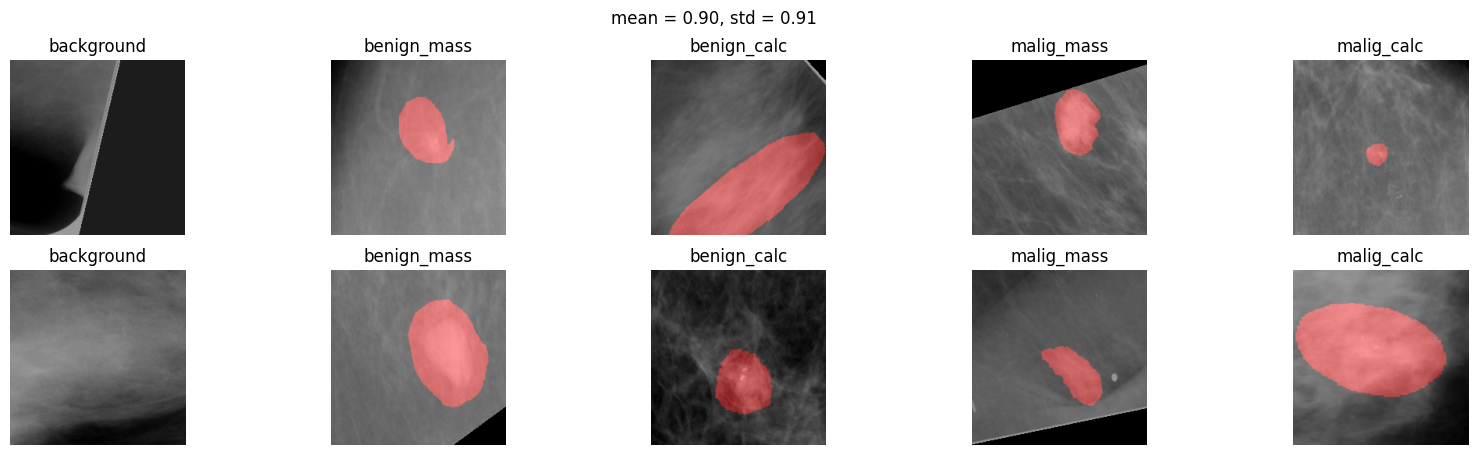

In [9]:
batch = next(iter(train_dl))
show_batch(batch)

## Probar patchdatamodule

{'General': {'source_root': '/home/eblanov/proymam2/Mammography/mamo_holistic', 'gpu_type': 'RTX 3090'}, 'Datamodule': {'num_classes': 5, 'batch_size': 35, 'num_workers': 16, 'train_set': {'convert_to_rgb': True, 'split_csv': 'resources/ddsm/DDSM_train.csv', 'ddsm_annotations': 'resources/ddsm/ddsm_annotations.json.gz', 'patch_size': 224, 'ddsm_root': '/home/Data/mamo/DDSM_png_16bit_1120x896', 'pin_memory': True}, 'val_set': {'eval_patches_root': '/home/Data/mamo/eval_patches_16bits_224_test_nikulin', 'subset_size_test': 100, 'subset_size_train': 1000}}, 'Logger': {'type': 'wandb', 'project': 'ddsm_patch', 'name': 'patches_224', 'save_dir': '/tmp/logs/ddsm_patch_224'}, 'LightningModule': {'model_name': 'resnet18', 'learning_rate': 0.001, 'optimizer_type': 'adam', 'num_classes': 5, 'lr_scheduler': 'ReduceLROnPlateau', 'lr_scheduler_options': {'mode': 'min', 'factor': 0.5, 'patience': 20, 'min_lr': 1e-08}}, 'Trainer': {'max_epochs': 200}, 'Callbacks': {'LearningRateMonitor': {'logging_in

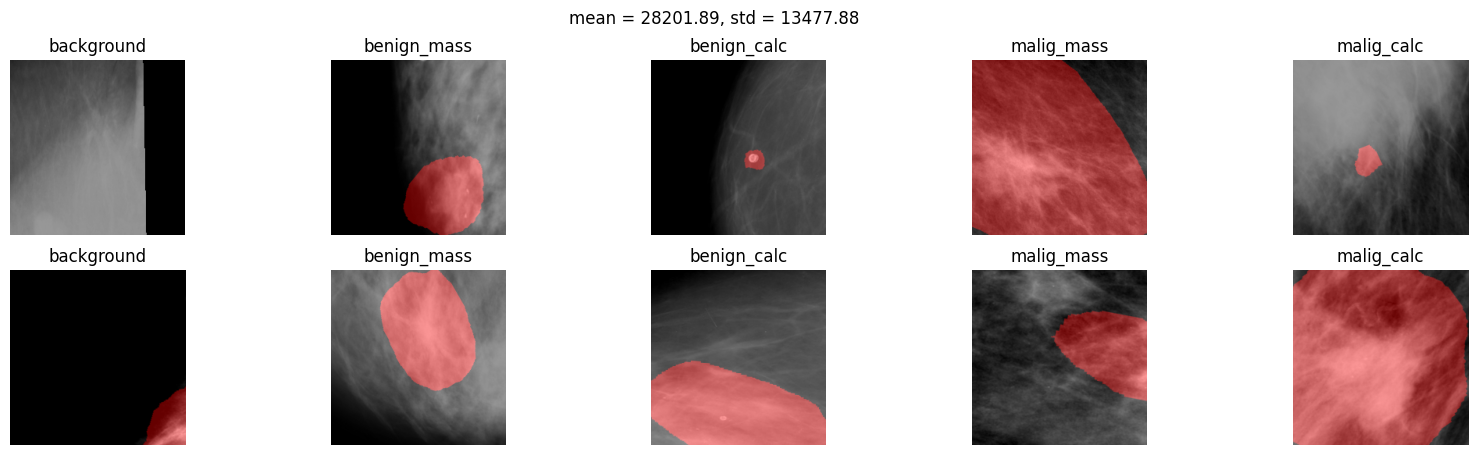

In [12]:
from data.ddsm_dataset import DDSMPatchDataModule
from utils.load_config import load_config

config = load_config('../config_files/base_config.yaml')
print(config)
dm = DDSMPatchDataModule(config)

train_dl = dm.train_dataloader()
batch = next(iter(train_dl))
show_batch(batch)

## Dataset Image

In [ ]:
from data.ddsm_dataset import DDSMImageDataModule
from utils.load_config import load_config

config = load_config('../config_files/base_config_image.yaml')

In [ ]:
dm = DDSMImageDataModule(config)


# train_dl = get_train_dataloader(split_csv, ddsm_annotations, root_dir, patch_size, batch_size=30, 
#                         convert_to_rgb = convert_to_rgb, shuffle=True, num_workers=4, return_mask=True, 
#                         subset_size=None, include_normals=include_normals,
#                         normalize_input = True) 

train_dl = dm.train_dataloader()
train_ds = train_dl.dataset
print("Num images in train dataset: ", len(train_ds))
train_ds.ddsm_annotations

Number of images in split:  7876
Number of images after assgining labels:  7876  Images without annotations (other breasts in cancer/bening folders):  2715
Using balanced batch sampler
Num images in train dataset:  7876


,image_id,mask_id,breast_malignant
0,cancers/cancer_12/case4108/D_4108_1.RIGHT_CC.png,None,False
1,cancers/cancer_12/case4108/D_4108_1.RIGHT_MLO.png,None,False
2,normals/normal_08/case4568/D_4568_1.RIGHT_CC.png,None,False
3,normals/normal_08/case4568/D_4568_1.RIGHT_MLO.png,None,False
4,normals/normal_04/case0416/A_0416_1.LEFT_CC.png,None,False
...,...,...,...
7871,benigns/benign_03/case1455/A_1455_1.RIGHT_MLO.png,None,False
7872,benigns/benign_07/case1302/A_1302_1.LEFT_CC.png,benigns/benign_07/case1302/A_1302_1.LEFT_CC_to...,False
7873,benigns/benign_07/case1302/A_1302_1.LEFT_MLO.png,benigns/benign_07/case1302/A_1302_1.LEFT_MLO_t...,False
7874,normals/normal_06/case0610/A_0610_1.LEFT_CC.png,None,False


¿DETECTOR BINARIO?¿CÁNCER NO CÁNCER?

In [ ]:
all_targets = train_ds.get_all_targets()

# count instances per class
from collections import Counter
Counter(all_targets)

Counter({np.False_: 6364, np.True_: 1512})

78750
tensor(2.5302e-08) tensor(1.)


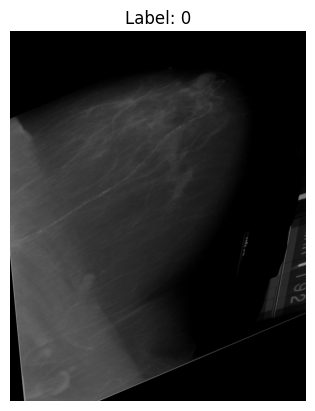

In [ ]:
n=0
# while n<=7875:
   # image=train_ds[n][0]
  #  label=train_ds[n][1]
 #   mask=train_ds[n][2]

 #   if mask.sum()!=0:# busca entre todas las imágenes si alguna tiene máscara
  #      break
   # print(f"\r{n}", end="")
    #n+=1

print(mask.sum())

show_mask_image(image[0], mask, title=f"Label: {label}", multi_label=True)
print(image.mean(), image.std())